**Robot navigation in a maze**

Assignment: Amy K. Hoover; 12/2020
Maze Code: Mark Nelson, 12/2019
ANN Code: Aaron Dharna; 10/27/2020  
Evolutionary Computation Code: Aaron Dharna; 11/20/2020

Algorithms added: CMA-ES and PEPG

Comared with GA

Added customMaze

# PREAMBLE

## Save


In [23]:

from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive
folderName = 'IS698_Homework4'
saveFolderName = './maps'

import os
if not os.path.exists(folderName):
  os.mkdir(folderName)
%cd {folderName}
if not os.path.exists(saveFolderName):
  os.mkdir(saveFolderName)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive/IS698_Homework4
/content/drive/My Drive/IS698_Homework4/IS698_Homework4


## Maze Navigation Environment

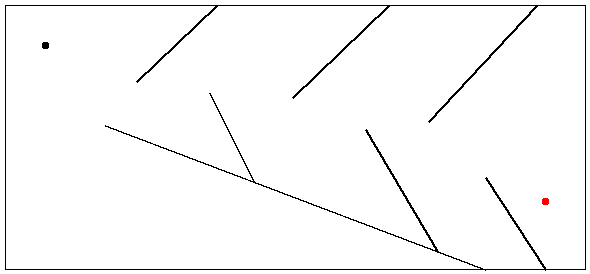

In [24]:
########
##PARAMETERS
########
# robot max speed, in world units per timestep
speed = 0.1

# epsilon distance for considering goal reached, collisions, etc.
epsilon = 0.01
sqEpsilon = epsilon**2

# interval to update visualization
visInterval = 20

# max simulation timesteps
timeout = 400
########
##UTILITY
########
from shapely.geometry import Point, LineString
import copy

def sqDistance(pos1, pos2):
    return (pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2

def isGoal(state):
    return sqDistance(state['position'], state['goal']) < sqEpsilon

# direction a given offset from the current heading, after normalizing (all in radians)
def newHeading(currentHeading, amount):
    return (currentHeading + amount) % (math.pi * 2.0)

# distance to the nearest obstacle in a given direction
def rangeSensor(pos, direction, obstacles, maxDist):
    pos2 = (pos[0] + math.cos(direction) * maxDist,
          pos[1] + math.sin(direction) * maxDist)
    testray = LineString([pos, pos2])
    collisions = [testray.intersection(obstacle) for obstacle in obstacles]
    posPt = Point(pos[0], pos[1])
    distances = [posPt.distance(c) for c in collisions if c]
    try:
        o = min(distances)
    except: 
        o = 0.01
    return o


#####################################
###########VISUALIZATION
############################################
import math
from PIL import Image, ImageDraw
from IPython.display import display


scalefactor = 40 # pixels per 'maze unit' for vis purposes
border = 5       # in pixels
markersize = 3   # in pixels, should be even
linewidth = 2    # in pixels

# convert world-space coordinate to pixel coordinate
def coord(x):
    if type(x) is list:
        return [coord(elem) for elem in x]
    elif type(x) is tuple:
        return tuple(coord(elem) for elem in x)
    else:
        return int(scalefactor*x) + border

# returns bounds for ImageDraw.Draw.ellipse()
def marker(x):
    return list(i - markersize for i in coord(x)) + list(i + markersize for i in coord(x))


def showmaze(m,i):
    width = m['dimensions'][0]
    height = m['dimensions'][1]
    img = Image.new("RGB", (int(width*scalefactor) + 2*border, int(height*scalefactor) + 2*border), 'white')
    img1 = ImageDraw.Draw(img)
    img1.rectangle(coord([0.0, 0.0, width, height]), None, 'black')
    img1.ellipse(marker(m['position']), 'black')
    img1.ellipse(marker(m['goal']), 'red')
    for obstacle in m['obstacles']:
        img1.line(coord(obstacle), 'black', linewidth)
    mazeNamePNG = "maze_" + str(i) + ".png"
    img.save('./maps/' + mazeNamePNG)
    display(img)

mediumMaze = {
    'dimensions': (14.5, 6.6),

    # obstacles are lines specified as [(x1,y1),(x2,y2)],
    #   where (0,0) is the top-left corner of the world
    # the four walls around the world are implicit and don't need to be specified
    'obstacles': [[(2.5, 3.0),(12.0, 6.6)], [(5.1, 2.2), (6.2, 4.4)],
                  [(9.0, 3.1), (10.8, 6.15)], [(12.0, 4.3), (13.5, 6.6)],
                  [(3.3, 1.9), (5.3, 0.0)], [(7.2, 2.3), (9.6, 0.0)],
                  [(10.6, 2.9), (13.3, 0.0)]],
   
    'position': (1.0, 1.0),
    'heading': 0, # in radians. 0 is to the right (+x axis); increasing heading rotates clockwise
    'goal': (13.5, 4.9),
}

showmaze(mediumMaze,0)


 

"Hard" maze:

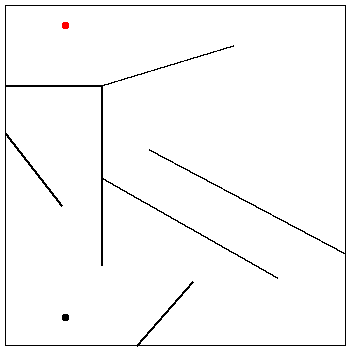

In [25]:
hardMaze = {
    'dimensions': (8.5, 8.5),

    'obstacles': [[(0.0, 2.0), (2.4, 2.0)], [(2.4, 2.0), (5.7, 1.0)],
                  [(2.4, 2.0), (2.4, 6.5)], [(0.0, 3.2), (1.4, 5.0)],
                  [(2.4, 4.3), (6.8, 6.8)], [(3.3, 8.5), (4.7, 6.9)],
                  [(3.6, 3.6), (8.5, 6.2)]],
   
    'position': (1.5, 7.8),
    'heading': 0,
    'goal': (1.5, 0.5),
}

showmaze(hardMaze,0)

Custom Maze

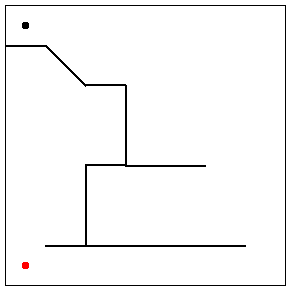

In [26]:
customMaze = {
    'dimensions': (7, 7),

    'obstacles': [[ (0.0, 1.0),(1.0, 1.0)], [(1.0, 1.0),(2.0, 2.0) ],
                  [(3.0, 2.0),(2.0, 2.0) ], [ (3.0, 2.0),(3.0, 4.0)],
                  [(3.0, 4.0),(2.0, 4.0) ], [(2.0, 4.0),(2.0, 6.0) ],
                  [(1.0, 6.0),(6.0, 6.0) ], [(3.0, 4.0),(5.0, 4.0)]],
   
    'position': (0.5, 0.5),
    'heading': 0,
    'goal': (0.5, 6.5),
}

showmaze(customMaze,0)

In [27]:
def runSimulation(initState, controller, render=True):
    state = copy.copy(initState)
    timestep = 0

    # add the 4 edges as pseudo-obstacles,
    # and cache the shapely.geometry.LineString versions, since obstacles don't move
    obstacles = [LineString(obstacle) for obstacle in state['obstacles']]
    (width, height) = state['dimensions']
    obstacles += [LineString([(0.0, 0.0), (width, 0.0)]),
                LineString([(0.0, 0.0), (0.0, height)]),
                LineString([(width, 0.0), (width, height)]),
                LineString([(0.0, height), (width, height)])]
    maxDist = math.sqrt(width**2 + height**2) # max distance between points in the maze

    # print("Initial state:")
    showmaze(state,timestep) if render else None
    # print(state['position'])
    
    while not isGoal(state) and timestep < timeout:
    # bookkeeping and state vis
        timestep += 1
        if (timestep % visInterval == 0 or timestep == 399) and render:
            print(f"Step {timestep}:")
            showmaze(state, timestep)

        # update sensors
        # six range sensors, angled (in order): left, left-center, center, right-center, right, back
        rangeSensorDirections = [-math.pi/2, -math.pi/4, 0, math.pi/4, math.pi/2, math.pi]
        rangeSensors = [rangeSensor(state['position'], newHeading(state['heading'], direction), obstacles, maxDist)
                        for direction in rangeSensorDirections]
        # wedge sensor, as a 4-element one-hot encoding
        # angleToGoal is relative to heading, normalized to [0, 2pi], where 0 is forward
        angleToGoal = (math.atan2(state['goal'][1] - state['position'][1], state['goal'][0] - state['position'][0]) - state['heading']) % (math.pi * 2.0)
        if 0.25*math.pi < angleToGoal <= 0.75*math.pi:   # right
            wedgeSensors = [0.0, 0.0, 1.0, 0.0]
        elif 0.75*math.pi < angleToGoal <= 1.25*math.pi: # rear
            wedgeSensors = [0.0, 0.0, 0.0, 1.0]
        elif 1.25*math.pi < angleToGoal <= 1.75*math.pi: # left
            wedgeSensors = [1.0, 0.0, 0.0, 0.0]
        else:                                            # forward
            wedgeSensors = [0.0, 1.0, 0.0, 0.0]
        rangeSensors = [r / maxDist for r in rangeSensors]
        sensors = rangeSensors + wedgeSensors

#         if timestep == 1:
#             print(sensors)
#             print(controller(sensors))
#             import time; time.sleep(2)

        # query the controller
        (forwardBack, leftRight) = controller(sensors)
        movement = forwardBack * speed
        state['heading'] = newHeading(state['heading'], leftRight * math.pi)

        # collision detection and position updating:
        # since we only have a point agent and line-segment obstacles, we can skip a
        #   'real' physics engine and just look for whether our path on the next
        #   timestep would intersect an obstacle
        pos = state['position']
        if (movement >= 0.0):
            effectiveHeading = state['heading']
            effectiveMovement = movement
        else:
            effectiveHeading = newHeading(state['heading'], 2*math.pi)
            effectiveMovement = -movement
        distToCollision = rangeSensor(pos, effectiveHeading, obstacles, maxDist)
        if distToCollision <= effectiveMovement: # collision
          # bounce back epsilon from the collision point
            newpos = (pos[0] + math.cos(effectiveHeading) * (distToCollision - epsilon),
                    pos[1] + math.sin(effectiveHeading) * (distToCollision - epsilon))
        else:
            newpos = (pos[0] + math.cos(effectiveHeading) * effectiveMovement,
                    pos[1] + math.sin(effectiveHeading) * effectiveMovement)
        state['position'] = newpos

    if render:
        if isGoal(state):
            print(f"Goal reached in {timestep} steps:")
            showmaze(state, timestep)
        else:
            print(f"Timeout at {timestep} steps:")
            showmaze(state, timestep)
     
    # print(state['position'])
    return sqDistance(state['position'], state['goal']) #return distance to goal as fitness.


## Evolutionary Algorithm

In [28]:
!python -m pip install cma

def fit_func(weights):
    network.update(weights)
    return runSimulation(mediumMaze, ANNcontroller, render=False)
 

In [29]:
from tqdm import tqdm
def test_solver(solver):
    history = {}
    history['best'] = []
    
    for j in tqdm(range(solver.MAX_ITERATION)):
        print(f"{j} - Test")
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)

        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])

        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history['best'].append(result[1])
        history[j] = fitness_list

        if (j+1) % 1 == 0:
            print("fitness at iteration", (j+1), result[1])

    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history

In [30]:
# from EvolutionStrategy import ES
import numpy as np


class ES:
    def __init__(self, popsize, nParams, eliteRatio=0.1, max_iter=5000):
        
        self.popsize = popsize
        self.nParams = nParams
        self.population = np.random.randn(popsize, nParams)
        
        self.eliteRatio = eliteRatio
        self.nElites = int(popsize * eliteRatio)
        self.elites = np.zeros((self.nElites, nParams))
        self.eliteRewards = np.zeros(self.nElites)
        
        self.bestParams = None
        self.bestReward = np.inf
        
        self.firstPass = True
        
        self.MAX_ITERATION = max_iter
        
    
    def ask(self):
        
        population = []
        for i in range(self.popsize):
            population.append(self.__mutateFromElites())
        
        self.population = np.array(population)
        return population
    
    def tell(self, reward_list):
        assert(len(reward_list) == self.popsize)
        
        reward_list = np.array(reward_list)
        
        if self.firstPass:
            rewards = reward_list
            solutions = self.population
        else:
            rewards = np.concatenate([reward_list, self.eliteRewards])
            solutions = np.concatenate([self.population, self.elites])
        
        next_gen_ids = np.argsort(rewards)[0:self.nElites]
        # sort in increasing order, then slice to keep the best k. 
        # we want to minimize the distance to the goal.
        
        
        self.elites = solutions[next_gen_ids]
        self.eliteRewards = rewards[next_gen_ids]
        
        self.curr_best_reward = self.eliteRewards[0]
        
        # print(self.curr_best_reward, self.bestReward)
        
        if (self.curr_best_reward < self.bestReward) or self.firstPass:
            self.firstPass = False
            self.bestReward = self.curr_best_reward
            self.bestParams = self.elites[0]
        
        return 
    
    def result(self):
        return self.bestParams, self.bestReward, self.curr_best_reward
    
    def __mutateFromElites(self):
        ids = self.elites.shape[0]
        parent = self.elites[np.random.choice(range(ids))]
        child = parent + np.random.randn(self.nParams)
        return child

# from HaGA import SimpleGA
import numpy as np

class SimpleGA:
    '''Simple Genetic Algorithm.'''
    def __init__(self, num_params,      # number of model parameters
               sigma_init=0.1,        # initial standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,      # stop annealing if less than this
               popsize=256,           # population size
               elite_ratio=0.1,       # percentage of the elites
               forget_best=False,     # forget the historical best elites
               weight_decay=0.01,     # weight decay coefficient
              ):

        self.num_params = num_params
        self.sigma_init = sigma_init
        self.sigma_decay = sigma_decay
        self.sigma_limit = sigma_limit
        self.popsize = popsize

        self.elite_ratio = elite_ratio
        self.elite_popsize = int(self.popsize * self.elite_ratio)

        self.sigma = self.sigma_init
        self.elite_params = np.zeros((self.elite_popsize, self.num_params))
        self.elite_rewards = np.zeros(self.elite_popsize)
        self.best_param = np.zeros(self.num_params)
        self.best_reward = 0
        self.first_iteration = True
        self.forget_best = forget_best
        self.weight_decay = weight_decay

    def rms_stdev(self):
        return self.sigma # same sigma for all parameters.

    def ask(self):
        '''returns a list of parameters'''
        self.epsilon = np.random.randn(self.popsize, self.num_params) * self.sigma
        solutions = []

        def mate(a, b):
            c = np.copy(a)
            idx = np.where(np.random.rand((c.size)) > 0.5)
            c[idx] = b[idx]
            return c

        elite_range = range(self.elite_popsize)
        
        for i in range(self.popsize):
            idx_a = np.random.choice(elite_range)
            idx_b = np.random.choice(elite_range)
            child_params = mate(self.elite_params[idx_a], self.elite_params[idx_b])
            solutions.append(child_params + self.epsilon[i])

        solutions = np.array(solutions)
        self.solutions = solutions

        return solutions

    def tell(self, reward_table_result):
    # input must be a numpy float array
        assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."
    
        reward_table = np.array(reward_table_result)
    
        # if self.weight_decay > 0:
        #     l2_decay = compute_weight_decay(self.weight_decay, self.solutions)
        #     reward_table += l2_decay

        if self.forget_best or self.first_iteration:
            reward = reward_table
            solution = self.solutions
        else:
            reward = np.concatenate([reward_table, self.elite_rewards])
            solution = np.concatenate([self.solutions, self.elite_params])

        idx = np.argsort(reward)[0:self.elite_popsize]

        self.elite_rewards = reward[idx]
        self.elite_params = solution[idx]

        self.curr_best_reward = self.elite_rewards[0]
    
        if self.first_iteration or (self.curr_best_reward < self.best_reward):
            self.first_iteration = False
            self.best_reward = self.elite_rewards[0]
            self.best_param = np.copy(self.elite_params[0])

        if (self.sigma > self.sigma_limit):
            self.sigma *= self.sigma_decay

    def current_param(self):
        return self.elite_params[0]

    def set_mu(self, mu):
        pass

    def best_param(self):
        return self.best_param

    def result(self): # return best params so far, along with historically best reward, curr reward, sigma
        return (self.best_param, self.best_reward, self.curr_best_reward, self.sigma)

    




CMA-ES and PEPG (Parameter-exploring policy gradients)

from: https://github.com/hardmaru/estool/blob/master/es.py


In [31]:
import numpy as np

def compute_ranks(x):
  """
  Returns ranks in [0, len(x))
  Note: This is different from scipy.stats.rankdata, which returns ranks in [1, len(x)].
  (https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py)
  """
  assert x.ndim == 1
  ranks = np.empty(len(x), dtype=int)
  ranks[x.argsort()] = np.arange(len(x))
  return ranks

def compute_centered_ranks(x):
  """
  https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py
  """
  y = compute_ranks(x.ravel()).reshape(x.shape).astype(np.float32)
  y /= (x.size - 1)
  y -= .5
  return y

def compute_weight_decay(weight_decay, model_param_list):
  model_param_grid = np.array(model_param_list)
  return - weight_decay * np.mean(model_param_grid * model_param_grid, axis=1)

# adopted from:
# https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/optimizers.py

class Optimizer(object):
  def __init__(self, pi, epsilon=1e-08):
    self.pi = pi
    self.dim = pi.num_params
    self.epsilon = epsilon
    self.t = 0

  def update(self, globalg):
    self.t += 1
    step = self._compute_step(globalg)
    theta = self.pi.mu
    ratio = np.linalg.norm(step) / (np.linalg.norm(theta) + self.epsilon)
    self.pi.mu = theta + step
    return ratio

  def _compute_step(self, globalg):
    raise NotImplementedError


class BasicSGD(Optimizer):
  def __init__(self, pi, stepsize):
    Optimizer.__init__(self, pi)
    self.stepsize = stepsize

  def _compute_step(self, globalg):
    step = -self.stepsize * globalg
    return step

class SGD(Optimizer):
  def __init__(self, pi, stepsize, momentum=0.9):
    Optimizer.__init__(self, pi)
    self.v = np.zeros(self.dim, dtype=np.float32)
    self.stepsize, self.momentum = stepsize, momentum

  def _compute_step(self, globalg):
    self.v = self.momentum * self.v + (1. - self.momentum) * globalg
    step = -self.stepsize * self.v
    return step


class Adam(Optimizer):
  def __init__(self, pi, stepsize, beta1=0.99, beta2=0.999):
    Optimizer.__init__(self, pi)
    self.stepsize = stepsize
    self.beta1 = beta1
    self.beta2 = beta2
    self.m = np.zeros(self.dim, dtype=np.float32)
    self.v = np.zeros(self.dim, dtype=np.float32)

  def _compute_step(self, globalg):
    a = self.stepsize * np.sqrt(1 - self.beta2 ** self.t) / (1 - self.beta1 ** self.t)
    self.m = self.beta1 * self.m + (1 - self.beta1) * globalg
    self.v = self.beta2 * self.v + (1 - self.beta2) * (globalg * globalg)
    step = -a * self.m / (np.sqrt(self.v) + self.epsilon)
    return step

class CMAES:
  '''CMA-ES wrapper.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.10,       # initial standard deviation
               popsize=255,           # population size
               weight_decay=0.01):    # weight decay coefficient

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.popsize = popsize
    self.weight_decay = weight_decay
    self.solutions = None

    import cma
    self.es = cma.CMAEvolutionStrategy( self.num_params * [0],
                                        self.sigma_init,
                                        {'popsize': self.popsize,
                                        })

  def rms_stdev(self):
    sigma = self.es.result[6]
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    self.solutions = np.array(self.es.ask())
    return self.solutions

  def tell(self, reward_table_result):
    reward_table = -np.array(reward_table_result)
    if self.weight_decay > 0:
      l2_decay = compute_weight_decay(self.weight_decay, self.solutions)
      reward_table += l2_decay
    self.es.tell(self.solutions, (reward_table).tolist()) # convert minimizer to maximizer.

  def current_param(self):
    return self.es.result[5] # mean solution, presumably better with noise

  def set_mu(self, mu):
    pass

  def best_param(self):
    return self.es.result[0] # best evaluated solution

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    r = self.es.result
    return (r[0], -r[1], -r[1], r[6])



class PEPG:
  '''Extension of PEPG with bells and whistles.'''
  def __init__(self, num_params,             # number of model parameters
               sigma_init=0.10,              # initial standard deviation
               sigma_alpha=0.20,             # learning rate for standard deviation
               sigma_decay=0.999,            # anneal standard deviation
               sigma_limit=0.01,             # stop annealing if less than this
               sigma_max_change=0.2,         # clips adaptive sigma to 20%
               learning_rate=0.01,           # learning rate for standard deviation
               learning_rate_decay = 0.9999, # annealing the learning rate
               learning_rate_limit = 0.01,   # stop annealing learning rate
               elite_ratio = 0,              # if > 0, then ignore learning_rate
               popsize=256,                  # population size
               average_baseline=True,        # set baseline to average of batch
               weight_decay=0.01,            # weight decay coefficient
               rank_fitness=True,            # use rank rather than fitness numbers
               forget_best=True):            # don't keep the historical best solution

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_alpha = sigma_alpha
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.sigma_max_change = sigma_max_change
    self.learning_rate = learning_rate
    self.learning_rate_decay = learning_rate_decay
    self.learning_rate_limit = learning_rate_limit
    self.popsize = popsize
    self.average_baseline = average_baseline
    if self.average_baseline:
      assert (self.popsize % 2 == 0), "Population size must be even"
      self.batch_size = int(self.popsize / 2)
    else:
      assert (self.popsize & 1), "Population size must be odd"
      self.batch_size = int((self.popsize - 1) / 2)

    # option to use greedy es method to select next mu, rather than using drift param
    self.elite_ratio = elite_ratio
    self.elite_popsize = int(self.popsize * self.elite_ratio)
    self.use_elite = False
    if self.elite_popsize > 0:
      self.use_elite = True

    self.forget_best = forget_best
    self.batch_reward = np.zeros(self.batch_size * 2)
    self.mu = np.zeros(self.num_params)
    self.sigma = np.ones(self.num_params) * self.sigma_init
    self.curr_best_mu = np.zeros(self.num_params)
    self.best_mu = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_interation = True
    self.weight_decay = weight_decay
    self.rank_fitness = rank_fitness
    if self.rank_fitness:
      self.forget_best = True # always forget the best one if we rank
    # choose optimizer
    self.optimizer = Adam(self, learning_rate)

  def rms_stdev(self):
    sigma = self.sigma
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    self.epsilon = np.random.randn(self.batch_size, self.num_params) * self.sigma.reshape(1, self.num_params)
    self.epsilon_full = np.concatenate([self.epsilon, - self.epsilon])
    if self.average_baseline:
      epsilon = self.epsilon_full
    else:
      # first population is mu, then positive epsilon, then negative epsilon
      epsilon = np.concatenate([np.zeros((1, self.num_params)), self.epsilon_full])
    solutions = self.mu.reshape(1, self.num_params) + epsilon
    self.solutions = solutions
    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."

    reward_table = np.array(reward_table_result)
    
    if self.rank_fitness:
      reward_table = compute_centered_ranks(reward_table)
    
    if self.weight_decay > 0:
      l2_decay = compute_weight_decay(self.weight_decay, self.solutions)
      reward_table += l2_decay

    reward_offset = 1
    if self.average_baseline:
      b = np.mean(reward_table)
      reward_offset = 0
    else:
      b = reward_table[0] # baseline
      
    reward = reward_table[reward_offset:]
    if self.use_elite:
      idx = np.argsort(reward)[::-1][0:self.elite_popsize]
    else:
      idx = np.argsort(reward)[::-1]

    best_reward = reward[idx[0]]
    if (best_reward > b or self.average_baseline):
      best_mu = self.mu + self.epsilon_full[idx[0]]
      best_reward = reward[idx[0]]
    else:
      best_mu = self.mu
      best_reward = b

    self.curr_best_reward = best_reward
    self.curr_best_mu = best_mu

    if self.first_interation:
      self.sigma = np.ones(self.num_params) * self.sigma_init
      self.first_interation = False
      self.best_reward = self.curr_best_reward
      self.best_mu = best_mu
    else:
      if self.forget_best or (self.curr_best_reward > self.best_reward):
        self.best_mu = best_mu
        self.best_reward = self.curr_best_reward

    # short hand
    epsilon = self.epsilon
    sigma = self.sigma

    # update the mean

    # move mean to the average of the best idx means
    if self.use_elite:
      self.mu += self.epsilon_full[idx].mean(axis=0)
    else:
      rT = (reward[:self.batch_size] - reward[self.batch_size:])
      change_mu = np.dot(rT, epsilon)
      self.optimizer.stepsize = self.learning_rate
      update_ratio = self.optimizer.update(-change_mu) # adam, rmsprop, momentum, etc.
      #self.mu += (change_mu * self.learning_rate) # normal SGD method

    # adaptive sigma
    # normalization
    if (self.sigma_alpha > 0):
      stdev_reward = 1.0
      if not self.rank_fitness:
        stdev_reward = reward.std()
      S = ((epsilon * epsilon - (sigma * sigma).reshape(1, self.num_params)) / sigma.reshape(1, self.num_params))
      reward_avg = (reward[:self.batch_size] + reward[self.batch_size:]) / 2.0
      rS = reward_avg - b
      delta_sigma = (np.dot(rS, S)) / (2 * self.batch_size * stdev_reward)

      # adjust sigma according to the adaptive sigma calculation
      # for stability, don't let sigma move more than 10% of orig value
      change_sigma = self.sigma_alpha * delta_sigma
      change_sigma = np.minimum(change_sigma, self.sigma_max_change * self.sigma)
      change_sigma = np.maximum(change_sigma, - self.sigma_max_change * self.sigma)
      self.sigma += change_sigma

    if (self.sigma_decay < 1):
      self.sigma[self.sigma > self.sigma_limit] *= self.sigma_decay
    
    if (self.learning_rate_decay < 1 and self.learning_rate > self.learning_rate_limit):
      self.learning_rate *= self.learning_rate_decay

  def current_param(self):
    return self.curr_best_mu

  def set_mu(self, mu):
    self.mu = np.array(mu)
  
  def best_param(self):
    return self.best_mu

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_mu, self.best_reward, self.curr_best_reward, self.sigma)

## Plots

In [32]:
import pandas as pd


## Controller


In [33]:
import numpy as np
class NumpyNetwork:
    def __init__(self, sensorShape, hidden1, hidden2, output, activation=np.tanh):
        # N is batch size; D_in is input dimension;
        # H is hidden dimensions; D_out is output dimension.
        self.D_in = sensorShape
        self.H1 = hidden1
        self.H2 = hidden2
        self.D_out = output

        # Randomly initialize weights
        self.w1 = np.random.randn(self.D_in, self.H1)
        self.w2 = np.random.randn(self.H1, self.H2)
        self.w3 = np.random.randn(self.H2, self.D_out)
        
        self.activation = activation
        
        self.nParams = self.D_in * self.H1 + self.H1 * self.H2 + self.H2 * self.D_out

    def __call__(self, sensors):
        sensors = np.array(sensors)
        _h1 = sensors.dot(self.w1)
        h1 = self.activation(_h1)
        _h2 = h1.dot(self.w2)
        h2 = self.activation(_h2)
        return self.activation(h2.dot(self.w3))
    
    def update(self, newWeights):
        """Update weights of this network to a new set of (1D) passed-in weights"""
        
        assert(len(newWeights) == self.nParams)
        
        # get matrix sizes
        firstmatrix = self.D_in * self.H1
        secondmatrix = firstmatrix + self.H1 * self.H2
        thirdmatrix = secondmatrix + self.H2 * self.D_out
        
        # extract weights
        w1 = newWeights[:firstmatrix]
        w2 = newWeights[firstmatrix:secondmatrix]
        w3 = newWeights[secondmatrix:thirdmatrix]
        
        # update matrices 
        self.w1 = np.reshape(w1, self.w1.shape)
        self.w2 = np.reshape(w2, self.w2.shape)
        self.w3 = np.reshape(w3, self.w3.shape)

def ANNcontroller(sensors):
    return network(sensors)        

## Variables for Main

In [34]:
# Note: Because these variables are initialized to none, be sure to only run this code once (if wanting save data)
ESData = None
pltESData = None
dfES = None

GAData = None
pltGAData = None
dfGA = None

CMAESData = None
pltCMAESData = None
dfCMAES = None

PEPGData = None
pltPEPGData = None
dfPEPG = None

#MAIN



  0%|          | 0/50 [00:00<?, ?it/s]

0 - Test


  2%|▏         | 1/50 [00:15<12:24, 15.20s/it]

fitness at iteration 1 0.49989903
1 - Test


  4%|▍         | 2/50 [00:30<12:15, 15.32s/it]

fitness at iteration 2 0.4999018
2 - Test


  6%|▌         | 3/50 [00:45<11:57, 15.28s/it]

fitness at iteration 3 0.49989745
3 - Test


  8%|▊         | 4/50 [01:01<11:41, 15.25s/it]

fitness at iteration 4 0.49989608
4 - Test


 10%|█         | 5/50 [01:16<11:22, 15.16s/it]

fitness at iteration 5 0.4998965
5 - Test


 12%|█▏        | 6/50 [01:31<11:06, 15.14s/it]

fitness at iteration 6 0.4998965
6 - Test


 14%|█▍        | 7/50 [01:46<10:47, 15.07s/it]

fitness at iteration 7 0.499893
7 - Test


 16%|█▌        | 8/50 [02:01<10:32, 15.07s/it]

fitness at iteration 8 0.49989265
8 - Test


 18%|█▊        | 9/50 [02:16<10:14, 15.00s/it]

fitness at iteration 9 0.4998903
9 - Test


 20%|██        | 10/50 [02:30<09:59, 14.98s/it]

fitness at iteration 10 0.4998886
10 - Test


 22%|██▏       | 11/50 [02:46<09:47, 15.08s/it]

fitness at iteration 11 0.4998871
11 - Test


 24%|██▍       | 12/50 [03:01<09:30, 15.02s/it]

fitness at iteration 12 0.4998866
12 - Test


 26%|██▌       | 13/50 [03:15<09:13, 14.96s/it]

fitness at iteration 13 0.49988425
13 - Test


 28%|██▊       | 14/50 [03:30<08:55, 14.89s/it]

fitness at iteration 14 0.49988255
14 - Test


 30%|███       | 15/50 [03:45<08:40, 14.88s/it]

fitness at iteration 15 0.4998796
15 - Test


 32%|███▏      | 16/50 [04:00<08:24, 14.85s/it]

fitness at iteration 16 0.499879
16 - Test


 34%|███▍      | 17/50 [04:15<08:11, 14.89s/it]

fitness at iteration 17 0.4998772
17 - Test


 36%|███▌      | 18/50 [04:29<07:52, 14.77s/it]

fitness at iteration 18 0.49987805
18 - Test


 38%|███▊      | 19/50 [04:44<07:37, 14.75s/it]

fitness at iteration 19 0.49987522
19 - Test


 40%|████      | 20/50 [04:59<07:23, 14.79s/it]

fitness at iteration 20 0.4998751
20 - Test


 42%|████▏     | 21/50 [05:14<07:10, 14.86s/it]

fitness at iteration 21 0.4998724
21 - Test


 44%|████▍     | 22/50 [05:29<06:54, 14.80s/it]

fitness at iteration 22 0.49987176
22 - Test


 46%|████▌     | 23/50 [05:43<06:39, 14.79s/it]

fitness at iteration 23 0.49986678
23 - Test


 48%|████▊     | 24/50 [05:58<06:25, 14.84s/it]

fitness at iteration 24 0.49986884
24 - Test


 50%|█████     | 25/50 [06:13<06:10, 14.81s/it]

fitness at iteration 25 0.49986482
25 - Test


 52%|█████▏    | 26/50 [06:28<05:57, 14.88s/it]

fitness at iteration 26 0.49986586
26 - Test


 54%|█████▍    | 27/50 [06:43<05:41, 14.86s/it]

fitness at iteration 27 0.49986166
27 - Test


 56%|█████▌    | 28/50 [06:58<05:27, 14.90s/it]

fitness at iteration 28 0.49986365
28 - Test


 58%|█████▊    | 29/50 [07:13<05:11, 14.85s/it]

fitness at iteration 29 0.49985948
29 - Test


 60%|██████    | 30/50 [07:27<04:54, 14.72s/it]

fitness at iteration 30 0.4998565
30 - Test


 62%|██████▏   | 31/50 [07:42<04:39, 14.72s/it]

fitness at iteration 31 0.49985552
31 - Test


 64%|██████▍   | 32/50 [07:56<04:23, 14.64s/it]

fitness at iteration 32 0.4998526
32 - Test


 66%|██████▌   | 33/50 [08:11<04:08, 14.60s/it]

fitness at iteration 33 0.49985301
33 - Test


 68%|██████▊   | 34/50 [08:25<03:53, 14.59s/it]

fitness at iteration 34 0.4998532
34 - Test


 70%|███████   | 35/50 [08:40<03:40, 14.73s/it]

fitness at iteration 35 0.49984935
35 - Test


 72%|███████▏  | 36/50 [08:55<03:27, 14.81s/it]

fitness at iteration 36 0.4998477
36 - Test


 74%|███████▍  | 37/50 [09:10<03:11, 14.72s/it]

fitness at iteration 37 0.49984682
37 - Test


 76%|███████▌  | 38/50 [09:25<02:56, 14.72s/it]

fitness at iteration 38 0.49984443
38 - Test


 78%|███████▊  | 39/50 [09:39<02:40, 14.62s/it]

fitness at iteration 39 0.4998463
39 - Test


 80%|████████  | 40/50 [09:54<02:26, 14.66s/it]

fitness at iteration 40 0.49984184
40 - Test


 82%|████████▏ | 41/50 [10:08<02:11, 14.64s/it]

fitness at iteration 41 0.49983832
41 - Test


 84%|████████▍ | 42/50 [10:23<01:57, 14.63s/it]

fitness at iteration 42 0.4998376
42 - Test


 86%|████████▌ | 43/50 [10:38<01:42, 14.65s/it]

fitness at iteration 43 0.4998369
43 - Test


 88%|████████▊ | 44/50 [10:52<01:26, 14.47s/it]

fitness at iteration 44 0.4998345
44 - Test


 90%|█████████ | 45/50 [11:06<01:12, 14.49s/it]

fitness at iteration 45 0.4998321
45 - Test


 92%|█████████▏| 46/50 [11:21<00:58, 14.58s/it]

fitness at iteration 46 0.49982995
46 - Test


 94%|█████████▍| 47/50 [11:36<00:43, 14.57s/it]

fitness at iteration 47 0.49982905
47 - Test


 96%|█████████▌| 48/50 [11:50<00:29, 14.58s/it]

fitness at iteration 48 0.49983
48 - Test


 98%|█████████▊| 49/50 [12:05<00:14, 14.52s/it]

fitness at iteration 49 0.49982777
49 - Test


100%|██████████| 50/50 [12:19<00:00, 14.79s/it]

fitness at iteration 50 0.49982578
local optimum discovered by solver:
 [-0.10261592 -0.01603864  0.01903219 ...  0.08413255 -0.21875804
 -0.00184843]
fitness score at this local optimum: 0.49982578
           0           1           2   ...          47          48          49
0  112.703384  189.929730  195.017600  ...  198.621587  155.371833  205.936029
1  115.155615  104.030475   90.121576  ...   43.118406   63.083220  177.362844
2  200.843421  196.821780  205.976424  ...  195.151812   98.821971  155.760754
3  175.484014  193.271003  158.812361  ...  101.699899  175.334820  102.776484
4  200.044930  164.038672  115.469892  ...  205.993520  197.967601  160.665831
5  162.159648  175.687745  102.150351  ...  200.419451  184.897212   39.001113
6  107.033360   61.558411  127.364511  ...  205.958287  195.924538  205.921124
7  159.662925  121.270617  135.601153  ...   74.013915  205.756323   98.004222
8  165.897239  200.746505  186.070593  ...  197.712935  181.907934  151.131622
9  193.5498

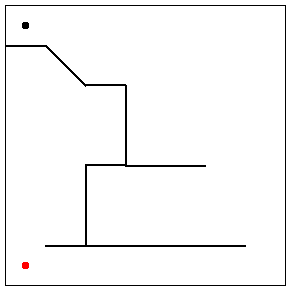

Step 20:


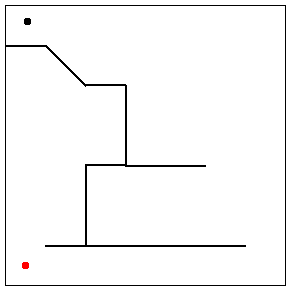

Step 40:


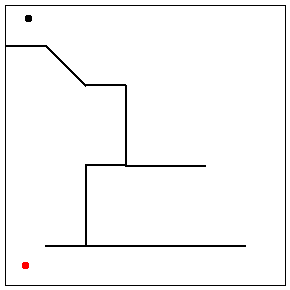

Step 60:


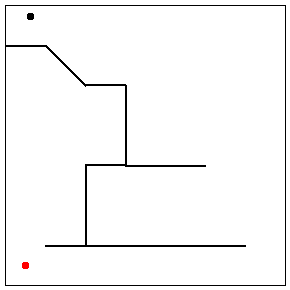

Step 80:


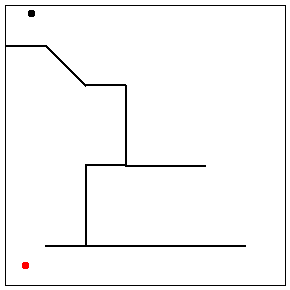

Step 100:


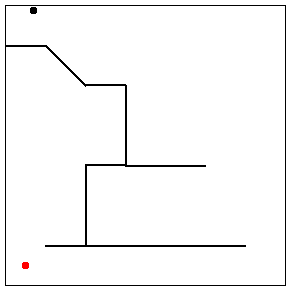

Step 120:


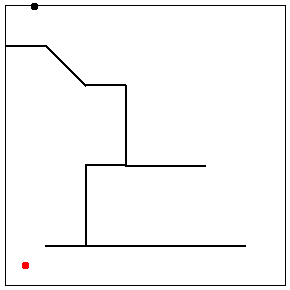

Step 140:


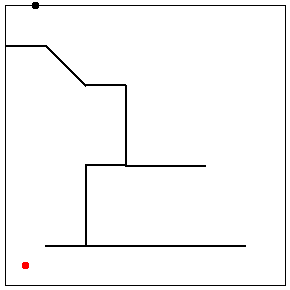

Step 160:


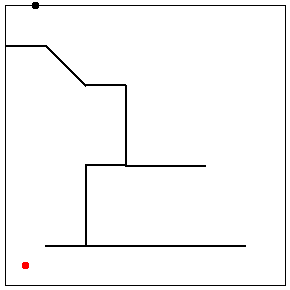

Step 180:


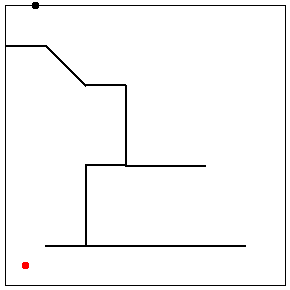

Step 200:


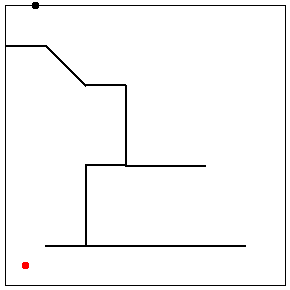

Step 220:


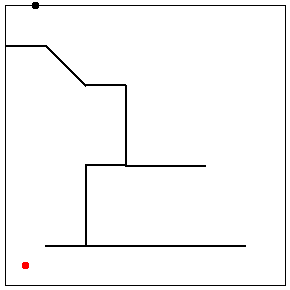

Step 240:


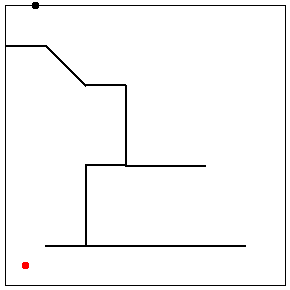

Step 260:


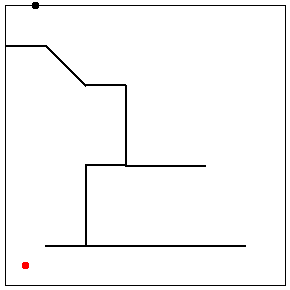

Step 280:


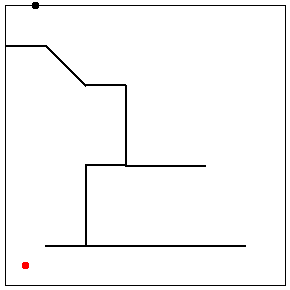

Step 300:


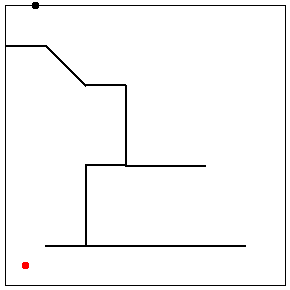

Step 320:


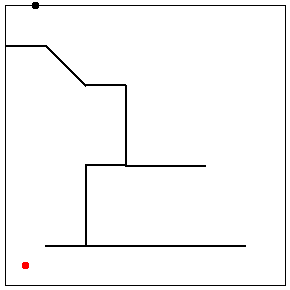

Step 340:


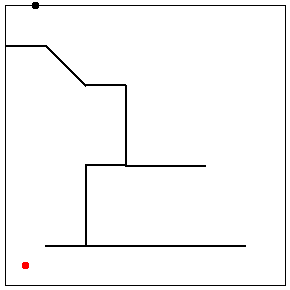

Step 360:


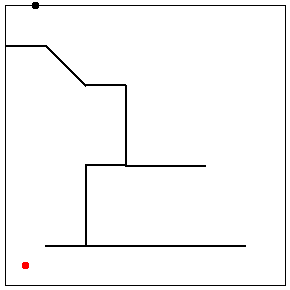

Step 380:


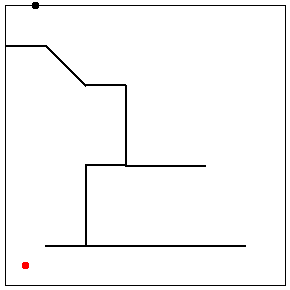

Step 399:


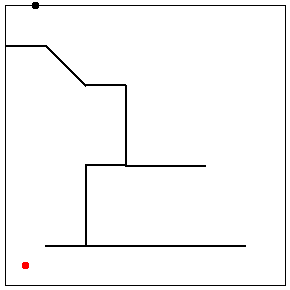

Step 400:


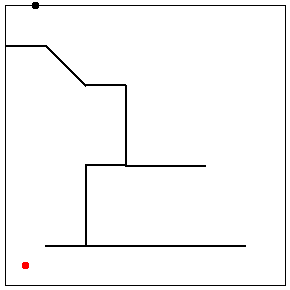

Timeout at 400 steps:


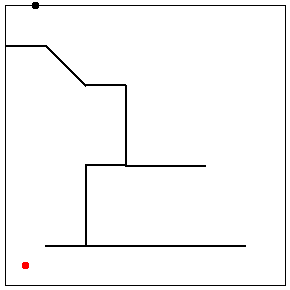

Data Frame: PEPG
           0           1           2   ...          47          48          49
0  112.703384  189.929730  195.017600  ...  198.621587  155.371833  205.936029
1  115.155615  104.030475   90.121576  ...   43.118406   63.083220  177.362844
2  200.843421  196.821780  205.976424  ...  195.151812   98.821971  155.760754
3  175.484014  193.271003  158.812361  ...  101.699899  175.334820  102.776484
4  200.044930  164.038672  115.469892  ...  205.993520  197.967601  160.665831
5  162.159648  175.687745  102.150351  ...  200.419451  184.897212   39.001113
6  107.033360   61.558411  127.364511  ...  205.958287  195.924538  205.921124
7  159.662925  121.270617  135.601153  ...   74.013915  205.756323   98.004222
8  165.897239  200.746505  186.070593  ...  197.712935  181.907934  151.131622
9  193.549858  139.225943  150.141845  ...   97.916861  157.424336  184.823026

[10 rows x 50 columns]


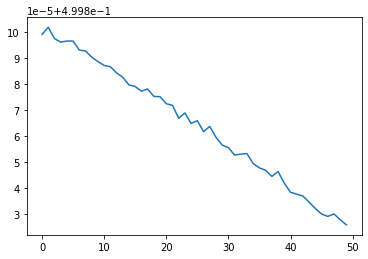

In [35]:
  
  import matplotlib.pyplot as plt
  #%matplotlib inline
  from tqdm import tqdm
  import os
  import numpy as np
  from shapely.geometry import Point, LineString
  import copy

  if __name__ == "__main__":

    network = NumpyNetwork(10, 128, 128, 2)
    #evoES = ES(popsize=10, nParams=network.nParams, max_iter=50)
    #evoGA = SimpleGA(popsize=10, num_params=network.nParams)
    #evoCMAES = CMAES(popsize=10,num_params=network.nParams)
    evoPEPG = PEPG(popsize=10,num_params=network.nParams)
    #evoCMAES.MAX_ITERATION = 100
    #evoGA.MAX_ITERATION = 50
    evoPEPG.MAX_ITERATION = 50
    controller = ANNcontroller
    maze = customMaze

    ### Evolution Strategy Code
    #if ESData == None:
    #  historyES = test_solver(evoES)
    #  ESData = historyES
    #  pltESData = plt.plot(historyES['best'])
    #  dfES = pd.DataFrame.from_dict({i:historyES[i] for i in range(evoES.MAX_ITERATION)})
    #  print(dfES)
    #  network.update(evoES.bestParams)
    #  runSimulation(maze, controller, render=True)

    ### Genetic Alg Code
    if GAData == None:
      historyGA = test_solver(evoGA)
      GAData = historyGA
      pltGAData = plt.plot(historyGA['best'])
      dfGA = pd.DataFrame.from_dict({i:historyGA[i] for i in range(evoGA.MAX_ITERATION)})
      print(dfGA)
      #print(evoGA.best_param)
      network.update(evoGA.best_param)
      runSimulation(maze, ANNcontroller, render=True)

    ### CMA-ES Code
    if CMAESData == None:
      historyCMAES = test_solver(evoCMAES)
      CMAESData = historyCMAES
      pltCMAESData = plt.plot(historyCMAES['best'])
      dfCMAES = pd.DataFrame.from_dict({i:historyCMAES[i] for i in range(evoCMAES.MAX_ITERATION)})
      print(dfCMAES)
      #print(evoCMAES.best_param)
      network.update(evoCMAES.best_param())
      runSimulation(maze, ANNcontroller, render=True)

    ### PEPG Code
    if PEPGData == None:
      historyPEPG = test_solver(evoPEPG)
      PEPGData = historyPEPG
      pltPEPGData = plt.plot(historyPEPG['best'])
      dfPEPG = pd.DataFrame.from_dict({i:historyPEPG[i] for i in range(evoPEPG.MAX_ITERATION)})
      print(dfPEPG)
      #print(evoPEPG.best_param)
      network.update(evoPEPG.best_param())
      runSimulation(maze, ANNcontroller, render=True)



    ##print
    #print('Data Frame: ES')
    #print(dfES)
    #plt.show()
    print('Data Frame: GA')
    print(dfGA)
    #plt.show()
    print('Data Frame: CMAES')
    print(dfCMAES)
    print('Data Frame: PEPG')
    print(dfPEPG)
    plt.show()


    

In [36]:
def ANNcontroller(sensors):
    return network(sensors)






# DOCUMENTATION

## Source: Lehman and Stanley (2011)

Adapted from:
* J. Lehman & K.O. Stanley (2011). Abandoning Objectives: Evolution Through the Search for Novelty Alone. *Evolutionary Computation* 19(2): 189-223. https://doi.org/10.1162/EVCO_a_00025.

In particular, the domain definition is based primarily on Figures 1-2 from that paper:

![Lehman & Stanley (2011), Figures 1-2](http://www.kmjn.org/temp/robotdomain.png)

## Code: Controller

The controller can move forward/back along the current heading, and rotate left/right to change heading (based on my intepretation of Fig. 1 at the top of this notebook). At each timestep it should return a 2-tuple:
* Forward/back speed, in the range [-1.0,1.0]. Max speed (i.e. -1.0 or 1.0) is equal to the 'speed' simulation parameter above, and lower speeds are linearly scaled.
* Left/right rotation, in the range [-1.0, 1.0]. Max rotation in either direction is 180 degrees. 0.0 means continue on the current heading, -0.5 means turn 90 degrees to the left, etc.

The controller is given a 10-element list with current sensor readings (see Fig. 1 again):
* The first six rangefinder sensors give the distance to the nearest obstacle in the directions: left, left-front, front, right-front, front, and rear (relative to current heading).
* The last four wedge sensors will have exactly one of the four set to 1.0, and the others to 0.0. The one set to 1.0 indicates the 90-degree quadrant that the goal is in, relative to the current heading. The order of the quadrants is: left, front, right, back.

Random controller:

In [37]:
import random
def randomController(sensors):
    # ignores sensors
    return (random.uniform(-1, 1), random.uniform(-1,1))

Go-straight controller:

In [38]:
def goStraight(sensors):
    # ignores sensors
    return (1.0, 0.0)

A controller that goes mostly straight, but avoids walls, mostly to test use of the sensors:

In [39]:
def goStraightAvoid(sensors):
    # go left-forward, forward, or right-forward, depending on which direction is furthest from obstacles
    if sensors[2] >= sensors[1] and sensors[2] >= sensors[3]:
        return (1.0, 0.0)        # go straight
    elif sensors[1] > sensors[3]:
        return (1.0, -0.25) # turn 45 degrees left
    return (1.0, 0.25)  # turn 45 degrees right

My ANN controller

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
import numpy as np
import os

In [42]:
class NumpyNetwork:
    def __init__(self, sensorShape, hidden1, hidden2, output, activation=np.tanh):
        # N is batch size; D_in is input dimension;
        # H is hidden dimensions; D_out is output dimension.
        self.D_in = sensorShape
        self.H1 = hidden1
        self.H2 = hidden2
        self.D_out = output

        # Randomly initialize weights
        self.w1 = np.random.randn(self.D_in, self.H1)
        self.w2 = np.random.randn(self.H1, self.H2)
        self.w3 = np.random.randn(self.H2, self.D_out)
        
        self.activation = activation
        
        self.nParams = self.D_in * self.H1 + self.H1 * self.H2 + self.H2 * self.D_out

    def __call__(self, sensors):
        sensors = np.array(sensors)
        _h1 = sensors.dot(self.w1)
        h1 = self.activation(_h1)
        _h2 = h1.dot(self.w2)
        h2 = self.activation(_h2)
        return self.activation(h2.dot(self.w3))
    
    def update(self, newWeights):
        """Update weights of this network to a new set of (1D) passed-in weights"""
        
        assert(len(newWeights) == self.nParams)
        
        # get matrix sizes
        firstmatrix = self.D_in * self.H1
        secondmatrix = firstmatrix + self.H1 * self.H2
        thirdmatrix = secondmatrix + self.H2 * self.D_out
        
        # extract weights
        w1 = newWeights[:firstmatrix]
        w2 = newWeights[firstmatrix:secondmatrix]
        w3 = newWeights[secondmatrix:thirdmatrix]
        
        # update matrices 
        self.w1 = np.reshape(w1, self.w1.shape)
        self.w2 = np.reshape(w2, self.w2.shape)
        self.w3 = np.reshape(w3, self.w3.shape)
        